In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from scipy.spatial import distance
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import measure
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.util import invert
from skimage.morphology import skeletonize, thin, medial_axis
from scipy.ndimage import gaussian_filter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.filters import frangi, sato
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import pywt


In [10]:
!pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.2 MB 2.4 MB/s eta 0:00:02
   --------- ------------------------------ 1.0/4.2 MB 2.8 MB/s eta 0:00:02
   ----------------- ---------------------- 1.8/4.2 MB 2.9 MB/s eta 0:00:01
   ------------------------ --------------- 2.6/4.2 MB 3.0 MB/s eta 0:00:01
   ----------------------------- ---------- 3.1/4.2 MB 3.1 MB/s eta 0:00:01
   ------------------------------------- -- 3.9/4.2 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 3.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


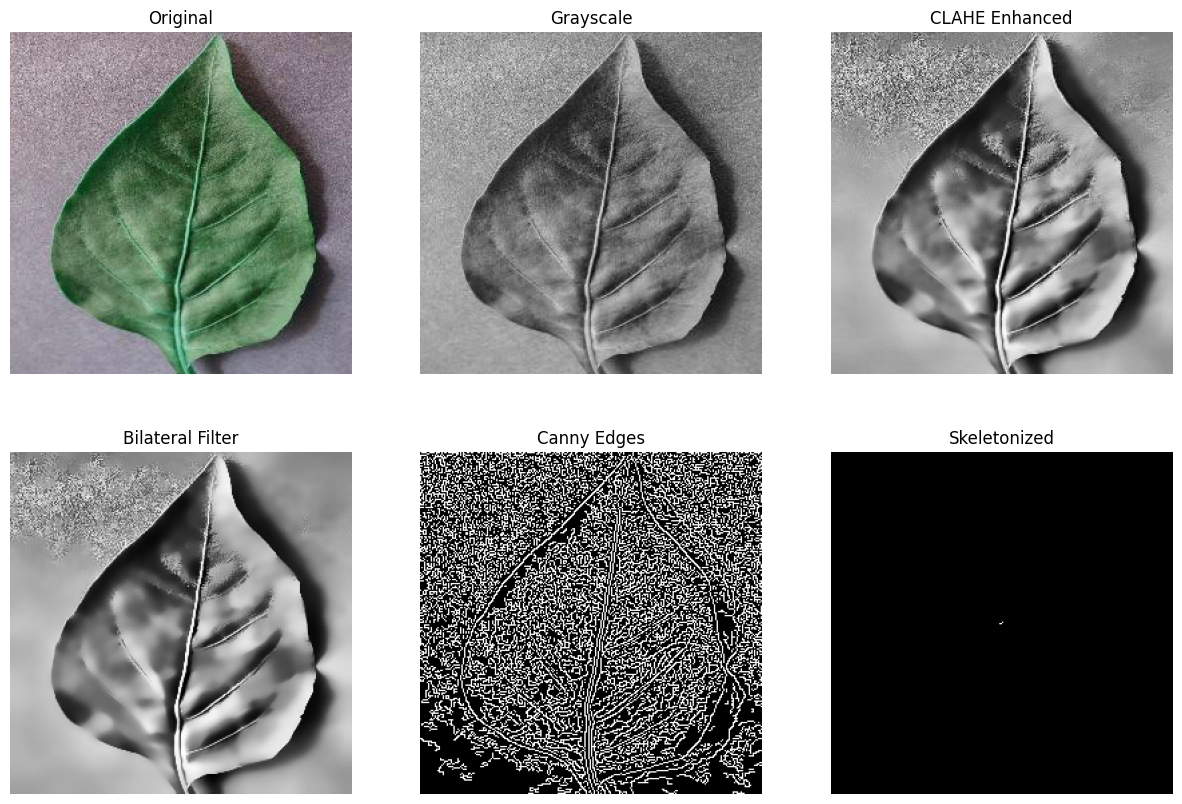

In [5]:
# Function to load and convert to grayscale
def load_and_convert_to_gray(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

# Function to apply Non-Local Means Denoising
def apply_non_local_means_denoising(gray):
    return cv2.fastNlMeansDenoising(gray, h=10, templateWindowSize=7, searchWindowSize=21)

# Function to apply Gaussian Blur
def apply_gaussian_blur(gray):
    return cv2.GaussianBlur(gray, (5, 5), 0)

# Function to apply CLAHE
def apply_clahe(gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

# Function to apply Bilateral Filter
def apply_bilateral_filter(gray):
    return cv2.bilateralFilter(gray, d=9, sigmaColor=30, sigmaSpace=1000)

# Function to apply Adaptive Thresholding
def apply_adaptive_thresholding(gray):
    return cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 5
    )

# Function to apply High-Pass Filter
def apply_high_pass_filter(gray):
    blurred_hpf = cv2.GaussianBlur(gray, (5,5), 0)
    high_pass = cv2.subtract(gray, blurred_hpf)
    return cv2.add(gray, high_pass)

# Function to apply Canny Edge Detection
def apply_canny_edge_detection(gray, min_val, max_val):
    return cv2.Canny(gray, min_val, max_val)

# Function to apply Morphological Opening
def apply_morph_opening(image, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)

# Function to calculate Hessian matrix and eigenvalues
def calculate_hessian_eigenvalues(image, sigma=3):
    hessian_matrices = hessian_matrix(image, sigma=sigma, use_gaussian_derivatives=False)
    eig1, eig2 = hessian_matrix_eigvals(hessian_matrices)
    _, binary_image = cv2.threshold(eig2, 125, 255, cv2.THRESH_BINARY)
    return binary_image

# Function to perform skeletonization
def perform_skeletonization(binary_image):
    binary_image_inverted = invert(binary_image // 255)
    return skeletonize(binary_image_inverted)

# Function to display images in subplot
def display_images(images, titles, cols=3):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))
    for i in range(len(images)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Main Code Execution
image_path = r"C:\\Users\Admin\\align_together\\plant_detection\AlignTogether\\pepper_healthy.jpg"
image, gray = load_and_convert_to_gray(image_path)

# Apply filters and transformations
denoised_nlm = apply_non_local_means_denoising(gray)
blurred = apply_gaussian_blur(gray)
enhanced = apply_clahe(denoised_nlm)
denoised_bf = apply_bilateral_filter(enhanced)
adaptive_thresh = apply_adaptive_thresholding(denoised_nlm)
high_pass = apply_high_pass_filter(gray)
edges = apply_canny_edge_detection(gray, 30, 70)
opened = apply_morph_opening(adaptive_thresh)
binary_image = calculate_hessian_eigenvalues(enhanced)
skeleton = perform_skeletonization(binary_image)

# Display images
display_images(
    [image, gray, enhanced, denoised_bf, edges, skeleton],
    ['Original', 'Grayscale', 'CLAHE Enhanced', 'Bilateral Filter', 'Canny Edges', 'Skeletonized'],
    cols=3
)


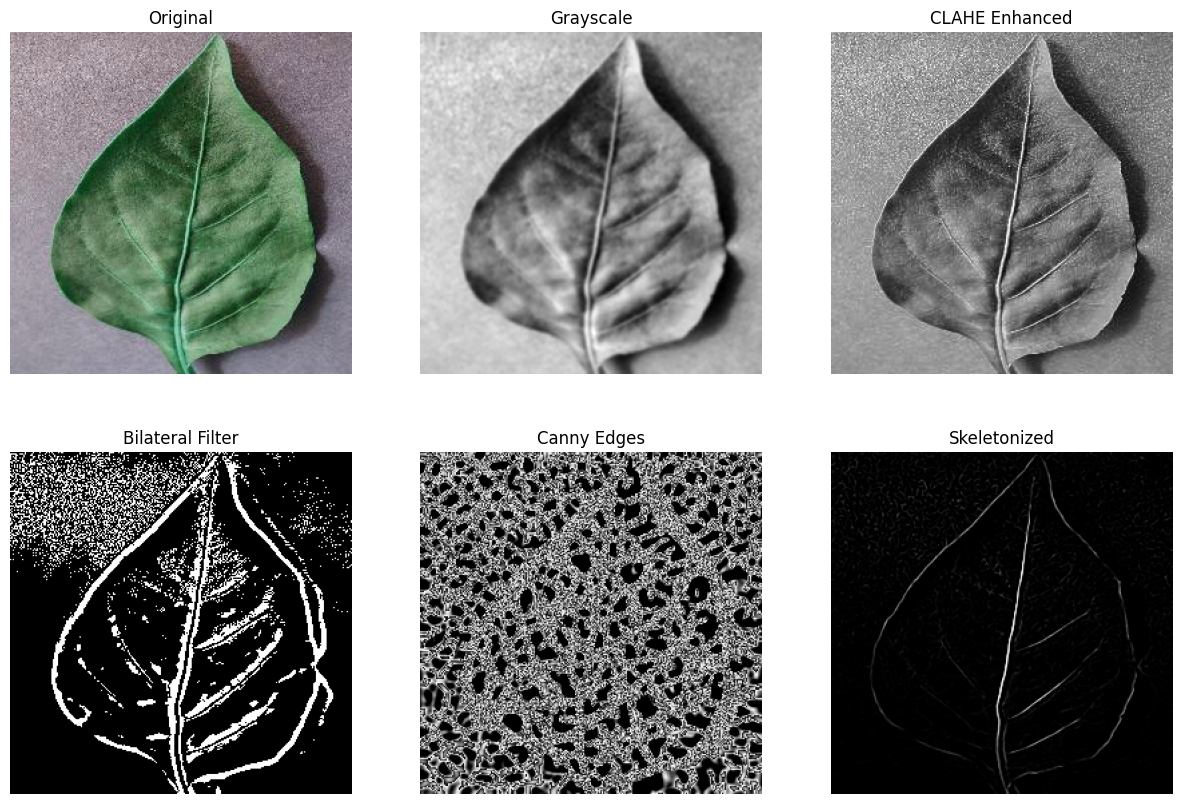

In [83]:
# Function to load and convert to grayscale
def load_and_convert_to_gray(image_path):
    # 'image_path' is the file path for the image to load.
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

# Function to apply Non-Local Means Denoising
def apply_non_local_means_denoising(gray):
    # Parameters to adjust:
    # 'h' - controls the strength of the filter (higher values mean stronger filtering).
    # 'templateWindowSize' - size of the template patch used for filtering (odd values only).
    # 'searchWindowSize' - size of the window used for searching patches (odd values only).
    return cv2.fastNlMeansDenoising(gray, h=10, templateWindowSize=7, searchWindowSize=21)

# Function to apply Gaussian Blur
def apply_gaussian_blur(gray):
    # Parameters to adjust:
    # Kernel size - tuple of odd integers, which controls the strength of the blur.
    return cv2.GaussianBlur(gray, (5, 5), 0)

# Function to apply CLAHE
def apply_clahe(gray):
    # Parameters to adjust:
    # 'clipLimit' - threshold for contrast clipping (higher values lead to higher contrast).
    # 'tileGridSize' - size of the grid for histogram equalization (smaller sizes enhance local contrast).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

# Function to apply Bilateral Filter
def apply_bilateral_filter(gray):
    # Parameters to adjust:
    # 'd' - diameter of each pixel neighborhood for filtering (larger values preserve more edges).
    # 'sigmaColor' - filter sigma in color space (larger values mean more smoothed regions).
    # 'sigmaSpace' - filter sigma in coordinate space (larger values mean more smoothed edges).
    return cv2.bilateralFilter(gray, d=9, sigmaColor=30, sigmaSpace=1000)

# Function to apply Adaptive Thresholding
def apply_adaptive_thresholding(gray):
    # Parameters to adjust:
    # 'maxValue' - the maximum intensity assigned to thresholded pixels.
    # 'blockSize' - size of the local region used to calculate the threshold.
    # 'C' - constant subtracted from the mean or weighted mean.
    return cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 5
    )

# Function to apply High-Pass Filter
def apply_high_pass_filter(gray):
    # Parameters to adjust:
    # Kernel size of Gaussian Blur - affects the sharpness of the high-pass filter.
    blurred_hpf = cv2.GaussianBlur(gray, (5,5), 0)
    high_pass = cv2.subtract(gray, blurred_hpf)
    return cv2.add(gray, high_pass)

# Function to apply Canny Edge Detection
def apply_canny_edge_detection(gray, min_val, max_val):
    # Parameters to adjust:
    # 'min_val' - lower threshold for edge detection.
    # 'max_val' - upper threshold for edge detection.
    return cv2.Canny(gray, min_val, max_val)

# Function to apply Morphological Opening
def apply_morph_opening(image, kernel_size=(3,3)):
    # Parameters to adjust:
    # 'kernel_size' - size of the kernel for morphological opening (larger sizes remove larger structures).
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)

# Function to calculate Hessian matrix and eigenvalues
def calculate_hessian_eigenvalues(image, sigma=3):
    # Parameters to adjust:
    # 'sigma' - controls the scale of the features detected (higher values detect larger structures).
    hessian_matrices = hessian_matrix(image, sigma=sigma, use_gaussian_derivatives=False)
    eig1, eig2 = hessian_matrix_eigvals(hessian_matrices)
    _, binary_image = cv2.threshold(eig2, 125, 255, cv2.THRESH_BINARY)
    return binary_image

# Function to perform skeletonization
def perform_skeletonization(binary_image):
    # Parameters to adjust:
    # No adjustable parameters for the 'skeletonize' function, which processes binary images.
    binary_image_inverted = invert(binary_image // 255)
    return skeletonize(binary_image_inverted)

# Function to display images in subplot
def display_images(images, titles, cols=3):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))
    for i in range(len(images)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Main Code Execution
image_path = r"C:\\Users\Admin\\align_together\\plant_detection\AlignTogether\\pepper_healthy.jpg"
image, gray = load_and_convert_to_gray(image_path)

# Apply filters and transformations
denoised_nlm = apply_non_local_means_denoising(gray)
blurred = apply_gaussian_blur(gray)
enhanced = apply_clahe(denoised_nlm)
denoised_bf = apply_bilateral_filter(enhanced)
adaptive_thresh = apply_adaptive_thresholding(denoised_nlm)
high_pass = apply_high_pass_filter(gray)
edges = apply_canny_edge_detection(gray, 70, 100)
opened = apply_morph_opening(adaptive_thresh)
binary_image = calculate_hessian_eigenvalues(enhanced)
skeleton = perform_skeletonization(binary_image)

# Applying Ridge Detection filters

# 2. Frangi Filter Ridge Detection
def frangi_ridge_detection(image):
    """
    Detects ridge structures using the Frangi filter.
    Parameters:
    - scale_range: tuple, min and max scales for multiscale detection.
    - beta1, beta2: control sensitivity to contrast and noise.
    """
    frangi_ridges = frangi(image,sigmas=range(1,10,2), scale_range=(1,5), alpha=0.5, beta=15, black_ridges= False)
    # return (frangi_ridges * 255).astype(np.uint8)
    return frangi_ridges


# 3. Sato Tubeness Filter Ridge Detection
def sato_ridge_detection(image):
    """
    Detects tubular structures using the Sato filter.
    Parameters:
    - scale_range: tuple, min and max scales for detection.
    """
    sato_ridges = sato(image, sigmas= range(3,5,5))
    return (sato_ridges * 255).astype(np.uint8)

# Apply filters and transformations
frangi_ridges = frangi_ridge_detection(high_pass)
sato_ridges = sato_ridge_detection(high_pass)

# Display images
display_images(
    [image, blurred, high_pass, adaptive_thresh, sato_ridges, frangi_ridges],
    ['Original', 'Grayscale', 'CLAHE Enhanced', 'Bilateral Filter', 'Canny Edges', 'Skeletonized'],
    cols=3
)


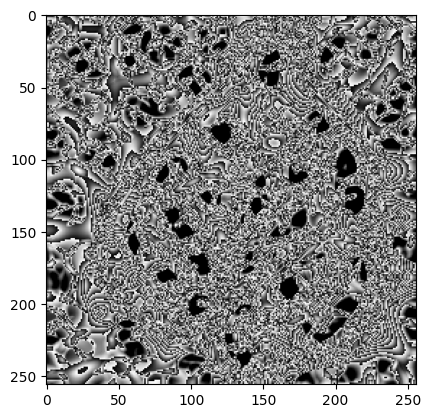

In [70]:
plt.imshow(sato_ridges, cmap='gray')

In [ ]:
# Function to load and convert to grayscale
def load_and_convert_to_gray(image_path):
    # 'image_path' is the file path for the image to load.
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

# Function to apply Non-Local Means Denoising
def apply_non_local_means_denoising(gray):
    # Parameters to adjust:
    # 'h' - controls the strength of the filter (higher values mean stronger filtering).
    # 'templateWindowSize' - size of the template patch used for filtering (odd values only).
    # 'searchWindowSize' - size of the window used for searching patches (odd values only).
    return cv2.fastNlMeansDenoising(gray, h=10, templateWindowSize=7, searchWindowSize=21)

# Function to apply Gaussian Blur
def apply_gaussian_blur(gray):
    # Parameters to adjust:
    # Kernel size - tuple of odd integers, which controls the strength of the blur.
    return cv2.GaussianBlur(gray, (5, 5), 0)

# Function to apply CLAHE
def apply_clahe(gray):
    # Parameters to adjust:
    # 'clipLimit' - threshold for contrast clipping (higher values lead to higher contrast).
    # 'tileGridSize' - size of the grid for histogram equalization (smaller sizes enhance local contrast).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

# Function to apply Bilateral Filter
def apply_bilateral_filter(gray):
    # Parameters to adjust:
    # 'd' - diameter of each pixel neighborhood for filtering (larger values preserve more edges).
    # 'sigmaColor' - filter sigma in color space (larger values mean more smoothed regions).
    # 'sigmaSpace' - filter sigma in coordinate space (larger values mean more smoothed edges).
    return cv2.bilateralFilter(gray, d=9, sigmaColor=30, sigmaSpace=1000)

# Function to apply Adaptive Thresholding
def apply_adaptive_thresholding(gray):
    # Parameters to adjust:
    # 'maxValue' - the maximum intensity assigned to thresholded pixels.
    # 'blockSize' - size of the local region used to calculate the threshold.
    # 'C' - constant subtracted from the mean or weighted mean.
    return cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 5
    )

# Function to apply High-Pass Filter
def apply_high_pass_filter(gray):
    # Parameters to adjust:
    # Kernel size of Gaussian Blur - affects the sharpness of the high-pass filter.
    blurred_hpf = cv2.GaussianBlur(gray, (5,5), 0)
    high_pass = cv2.subtract(gray, blurred_hpf)
    return cv2.add(gray, high_pass)

# Function to apply Canny Edge Detection
def apply_canny_edge_detection(gray, min_val, max_val):
    # Parameters to adjust:
    # 'min_val' - lower threshold for edge detection.
    # 'max_val' - upper threshold for edge detection.
    return cv2.Canny(gray, min_val, max_val)

# Function to apply Morphological Opening
def apply_morph_opening(image, kernel_size=(3,3)):
    # Parameters to adjust:
    # 'kernel_size' - size of the kernel for morphological opening (larger sizes remove larger structures).
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)

# Function to calculate Hessian matrix and eigenvalues
def calculate_hessian_eigenvalues(image, sigma=3):
    # Parameters to adjust:
    # 'sigma' - controls the scale of the features detected (higher values detect larger structures).
    hessian_matrices = hessian_matrix(image, sigma=sigma, use_gaussian_derivatives=False)
    eig1, eig2 = hessian_matrix_eigvals(hessian_matrices)
    _, binary_image = cv2.threshold(eig2, 125, 255, cv2.THRESH_BINARY)
    return binary_image

# Function to perform skeletonization
def perform_skeletonization(binary_image):
    # Parameters to adjust:
    # No adjustable parameters for the 'skeletonize' function, which processes binary images.
    binary_image_inverted = invert(binary_image // 255)
    return skeletonize(binary_image_inverted)

# Function to display images in subplot
def display_images(images, titles, cols=3):
    # Parameters to adjust:
    # 'cols' - the number of columns in the subplot (adjusts layout based on image count).
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))
    for i in range(len(images)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()


In [14]:
# 1. Hessian-Based Ridge Detection
def hessian_ridge_detection(image, sigma=3):
    """
    Detects ridges using the Hessian matrix.
    Parameters:
    - sigma: controls the scale of detection, higher for thicker ridges.
    """
    hessian_matrices = hessian_matrix(image, sigma=sigma, use_gaussian_derivatives=False)
    eig1, eig2 = hessian_matrix_eigvals(hessian_matrices)
    return (eig2 < 0).astype(np.uint8) * 255  # Binary image of detected ridges

# 2. Frangi Filter Ridge Detection
def frangi_ridge_detection(image, scale_range=(1, 5), beta1=0.5, beta2=15):
    """
    Detects ridge structures using the Frangi filter.
    Parameters:
    - scale_range: tuple, min and max scales for multiscale detection.
    - beta1, beta2: control sensitivity to contrast and noise.
    """
    frangi_ridges = frangi(image, scale_range=scale_range, beta1=beta1, beta2=beta2)
    return (frangi_ridges * 255).astype(np.uint8)

# 3. Sato Tubeness Filter Ridge Detection
def sato_ridge_detection(image, scale_range=(1, 5)):
    """
    Detects tubular structures using the Sato filter.
    Parameters:
    - scale_range: tuple, min and max scales for detection.
    """
    sato_ridges = sato(image, scale_range=scale_range)
    return (sato_ridges * 255).astype(np.uint8)

# 4. Wavelet-Based Ridge Detection
def wavelet_ridge_detection(image, wavelet='db2', level=2):
    """
    Detects ridges using wavelet transforms.
    Parameters:
    - wavelet: wavelet type (e.g., 'db2' for Daubechies).
    - level: level of wavelet decomposition.
    """
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    ridge_wavelet = np.sqrt(cH**2 + cV**2 + cD**2)
    return (ridge_wavelet * 255 / np.max(ridge_wavelet)).astype(np.uint8)

# 5. Gabor Filter-Based Ridge Detection
def gabor_ridge_detection(image, ksize=21, sigma=5, theta=np.pi/4, lamda=10, gamma=0.5):
    """
    Detects ridges using Gabor filters.
    Parameters:
    - ksize: size of the Gabor kernel.
    - sigma: standard deviation of the Gaussian envelope.
    - theta: orientation of the normal to the parallel stripes.
    - lamda: wavelength of the sinusoidal factor.
    - gamma: spatial aspect ratio.
    """
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma)
    gabor_ridges = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)
    return gabor_ridges

# 6. Laplacian of Gaussian (LoG) Ridge Detection
def log_ridge_detection(image, sigma=2):
    """
    Detects ridges using Laplacian of Gaussian (LoG).
    Parameters:
    - sigma: scale of Gaussian blur for feature detection.
    """
    blurred = gaussian_filter(image, sigma=sigma)
    log_ridges = cv2.Laplacian(blurred, cv2.CV_64F)
    return cv2.convertScaleAbs(log_ridges)

# 7. Sobel Ridge Detection
def sobel_ridge_detection(image):
    """
    Detects ridges using the Sobel operator.
    """
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_ridges = cv2.magnitude(sobelx, sobely)
    return cv2.convertScaleAbs(sobel_ridges)

# 8. Morphological Ridge Detection
def morphological_ridge_detection(image, kernel_size=(3,3)):
    """
    Detects ridges using morphological operations.
    Parameters:
    - kernel_size: size of the structuring element for morphology.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    return tophat

# Main Execution and Display
# Applying the functions and showing results
results = [
    ("Original", gray),
    ("Hessian Ridge", hessian_ridge_detection(gray)),
    ("Frangi Ridge", frangi_ridge_detection(gray)),
    ("Sato Ridge", sato_ridge_detection(gray)),
    ("Wavelet Ridge", wavelet_ridge_detection(gray)),
    ("Gabor Ridge", gabor_ridge_detection(gray)),
    ("LoG Ridge", log_ridge_detection(gray)),
    ("Sobel Ridge", sobel_ridge_detection(gray)),
    ("Morphological Ridge", morphological_ridge_detection(gray))
]

# Display results
plt.figure(figsize=(18, 12))
for i, (title, result) in enumerate(results):
    plt.subplot(3, 3, i + 1)
    plt.imshow(result, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.show()


TypeError: sato() got an unexpected keyword argument 'scale_range'